# Chapter 7: Combining Different Models for Ensemble Learning
In this chapter we will explore methods for combining the estimators from previous sections to increase the overall classification of the ML algorithm. Specifically, we will discuss:
1. The logic behind using ensembles of classifiers
2. Review of Ch. 6, combining classifiers via pipelines
3. Majority voting
4. Bagging (if time permits)

## Why Use Ensemble Learning?
It is purely a probalistic argument. 

Suppose you have 11 independent classifiers, each with a known accuracy of 0.80 for a two-class problem, and you decide to classify your data as whatever label the majority of the 11 classifiers show. The probability that you will get the correct classification with this ensemble can be calculated from the binomial distribution:
$$ \textrm{Accuracy} = \textrm{Prob}(X\geq 6; X=\textrm{bin}(n=11, p=0.8)) = \sum_{k=6}^{11} {11\choose k}(0.80)^k(0.2)^{11-k} = 0.98835 $$

Clearly an ensemble can perform much more accurately than each of its constituents. We will now look at different ways of exploiting and implementing ensemble learning techniques.

*Technical Note*: The ensemble will only perform better than the individual classifiers if the individual classifiers themselves perform better than random guessing.

## Majority Voting
Majority voting is the most straight forward method of ensemble learning: just chain together your favorite estimators / pipelines and compute the final classification of each data point.

Sebastian Raschka integrated a `VotingClassifier` in SK-Learn shortly after writing this book that can use majority voting (default) or other weighted voting schemes. The documentation for the SK-Learn module is available [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).

Let's start looking at how this module works by loading the Wisconsin Breast Cancer Dataset. As a reminder, this dataset documents 30 attributes of tumors with 2 class labels of maglignant and benign.

In [1]:
#Load Breast Cancer Dataset
import pandas as pd
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

#Drop the three most important columns to make problem more challenging
df = df.drop(labels=['worst radius', 'worst area', 'worst perimeter'], 
             axis=1)

#Create SK-Learn standard X and y arrays
X = df.values
y = cancer.target

Once we have the dataset loaded and preprocessed, we create training and test datasets

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

Now import a bunch of stuff

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
import numpy as np

Now we will create a few classifiers to form our ensemble

In [4]:
#Logistic Regression with standardized features
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])

#Decision Tree Classifier
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)

#KNN Classifier with standardized features
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

Let's see how these three classifiers do individually on our dataset. The metric used is the area under the classifier's ROC curve (ROC AUC).

In [20]:
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n-------------------------')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" \
          % (scores.mean(), scores.std(), label))

10-fold cross validation:
-------------------------
ROC AUC: 0.98 (+/- 0.01) [Logistic Regression]
ROC AUC: 0.90 (+/- 0.04) [Decision Tree]
ROC AUC: 0.95 (+/- 0.02) [KNN]


Not too bad, and not much room for improvement, but let's try combining the classifications of the three estimators. Classification now requires the agreement of two out of the three estimators. The implementation here uses the SK-Learn `VotingClassifier` module instead of the code presented in the book, but there are very few differences.

In [22]:
from sklearn.ensemble import VotingClassifier
mv_clf = VotingClassifier([('pipe1', pipe1), ('clf2', clf2), ('pipe3', pipe3)], 
                          voting='soft', 
                          n_jobs=-1)
mv_clf_label = 'Majority Voting'
mv_score = cross_val_score(estimator=mv_clf, 
                           X=X_train, 
                           y=y_train, 
                           cv=10, 
                           scoring='roc_auc')
print('Ensemble Learning:\n-------------------------')
print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (mv_score.mean(), mv_score.std(), mv_clf_label))

Ensemble Learning:
-------------------------
ROC AUC: 0.99 (+/- 0.01) [Majority Voting]


### Evaluation and Tuning
Since the first try for an ensemble learning algorithm might not always perform optimally (we got somewhat lucky here), we want to have metrics for performance as well as be able to see exaclty what the ensemble classifier is doing.

We can start with a ROC curve comparing the `'Majority Voting'` classifier to its constituents.

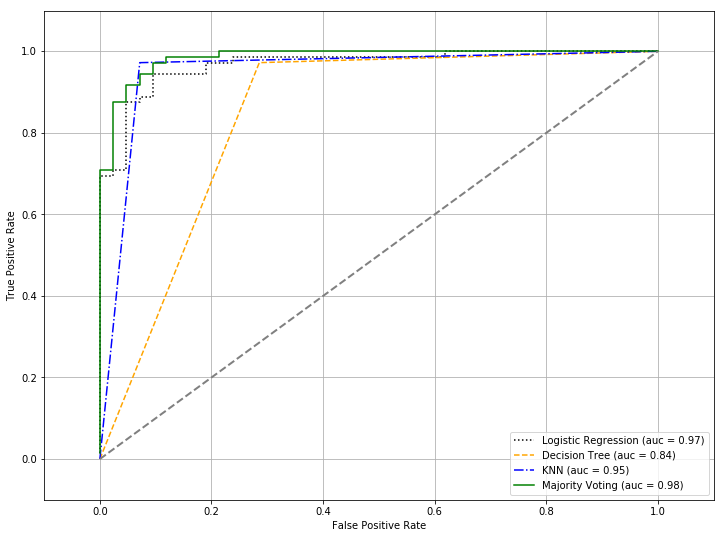

In [23]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Define plot characteristics
all_clf = [pipe1, clf2, pipe3, mv_clf]
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'Majority Voting']
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

#Plot the ROC curves
plt.figure(figsize=(12,9))
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
    
#Format the figure
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We can also inspect the parameters used in fitting each of the individual components in the ensemble, and observe directly how those parameters are folded into the ensemble itself via the `get_params()` method.

In [11]:
mv_clf.get_params()

{'estimators': [('pipe1', Pipeline(memory=None,
        steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False)]])),
  ('clf2',
   DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, presort=False, random_state=0,
               splitter='best')),
  ('pipe3', Pipeline(memory=None,
        steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           

Now let's suppose we want to improve our ensemble even further using the `GridSearch` techniques from Chapter 6. The implementation is straightforward, but you must adapt to the naming conventions shown in the output of the `get_params()` method.

In [24]:
from sklearn.model_selection import GridSearchCV
params = {'clf2__max_depth': [1, 2], 'pipe1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.3f %r" % (mean_score, scores.std() / 2, params))

0.989+/-0.006 {'clf2__max_depth': 1, 'pipe1__clf__C': 0.001}
0.992+/-0.004 {'clf2__max_depth': 1, 'pipe1__clf__C': 0.1}
0.987+/-0.009 {'clf2__max_depth': 1, 'pipe1__clf__C': 100.0}
0.990+/-0.005 {'clf2__max_depth': 2, 'pipe1__clf__C': 0.001}
0.992+/-0.004 {'clf2__max_depth': 2, 'pipe1__clf__C': 0.1}
0.991+/-0.005 {'clf2__max_depth': 2, 'pipe1__clf__C': 100.0}


c:\users\owner\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


To conclude this example, we can see that the ROC AUC value is maximized when the inverse of the regularization strength for the `LogisticRegressionClassifier` component of the ensemble is set to 0.1.

It is possible to expand the `GridSearch` to cover more of the parameter space and to include more classifiers in the ensemble in cases where the previous implementation is insufficient.